# Test of Structural Mechanics
We will now test the python interface of teh structural mechanics part.
For that we will use the test `test/test_model/test_structural_mechanics_model/test_structural_mechanics_model_bernoulli_beam_2.cc`, which we will simply reproduce.


In [1]:
try:
    import pyakantu as pyaka
except:
    print("Error importing pyakantu, try the other one")
    import py11_akantu as pyaka
    
import copy
import numpy

Error importing pyakantu, try the other one


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Creating the Mesh

In [3]:
# Create a mesh for the two dimensional case
beam = pyaka.Mesh(2)

We now create the connectivity array for the beam.

In [4]:
beam.addConnectivityType(pyaka._bernoulli_beam_2)

We need a `MeshAccessor` in order to change the size of the mesh entities.

In [5]:
beamAcc = pyaka.MeshAccessor(beam)

Now we create the array to store the nodes and the connectivities and give them their size. 

In [6]:
beamAcc.resizeConnectivity(2, pyaka._bernoulli_beam_2)
beamAcc.resizeNodes(3)

#### Setting the Nodes

In [7]:
Nodes = beam.getNodes()
Nodes[0, :] = [0., 0.]
Nodes[1, :] = [1., 0.]
Nodes[2, :] = [2., 0.]

#### Setting the Connections

In [8]:
Conn = beam.getConnectivity(pyaka._bernoulli_beam_2)
Conn[0, :] = [0, 1]
Conn[1, :] = [1, 2]

#### Ready
We have to make the mesh ready.

In [9]:
beamAcc.makeReady()

### Creating the Model

In [10]:
model = pyaka.StructuralMechanicsModel(beam)

#### Setting up the Modell

##### Creating and Inserting the Materials

In [11]:
mat1 = pyaka.StructuralMaterial()
mat1.E = 1e9
mat1.rho = 1.
mat1.I = 1.
mat1.Iz = 1.
mat1.Iy = 1.
mat1.A = 1.
mat1.GJ = 1.
model.addMaterial(mat1)

0

In [12]:
mat2 = pyaka.StructuralMaterial()
mat2.E = 1e9
mat2.rho = 1.
mat2.I = 1.
mat2.Iz = 1.
mat2.Iy = 1.
mat2.A = 1.
mat2.GJ = 1.
model.addMaterial(mat2)

1

In [13]:
mat3 = pyaka.StructuralMaterial()
mat3.E = mat2.E / 10000
mat3.rho = 0
mat3.I = 1.
mat3.Iz = 1.
mat3.Iy = 1.
mat3.A = mat2.A / 100
mat3.GJ = 1.
model.addMaterial(mat3)

2

##### Initializing the Model

In [14]:
model.initFull(pyaka.AnalysisMethod._implicit_dynamic)

##### Assigning the Materials

In [15]:
materials = model.getElementMaterialMap(pyaka.ElementType._bernoulli_beam_2)

In [16]:
materials[0][0] = 0
materials[1][0] = 1

##### Setting Boundaries

In [17]:
# Neumann
#  Apply a force of `10` at the last (right most) node.
forces = model.getExternalForce()
forces[:] = 0
forces[2, 0] = 100.

In [18]:
# Dirichlets
# Block all dofs of the first node, since it is fixed.
#  All other nodes have no restrictions
boundary = model.getBlockedDOFs()
boundary[0, :] = True
boundary[1, :] = False
boundary[2, :] = False
#boundary[2, 0] = True

### Solving the System

In [19]:
# Set up the system
deltaT = 1e-10
model.setTimeStep(deltaT)
solver = model.getNonLinearSolver()
solver.set("max_iterations", 100)
solver.set("threshold", 1e-8)
solver.set("convergence_type", pyaka.SolveConvergenceCriteria.solution)

In [20]:
# Perform N time steps.
#  At each step records the displacement of all three nodes in x direction.
N = 10000 
disp1 = np.zeros(N)
disp2 = np.zeros(N)
disp0 = np.zeros(N)
times = np.zeros(N)

for i in range(N):
    
    if(i == (N // 2)):
        materials[0][0] = 2
        materials[1][0] = 2
    model.solveStep()
    disp = model.getDisplacement()
    disp0[i] = disp[0, 0]
    disp1[i] = disp[1, 0]
    disp2[i] = disp[2, 0]
    times[i] = deltaT * i

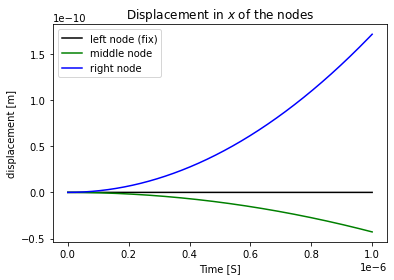

In [21]:
plt.plot(times, disp0, color='k', label = "left node (fix)")
plt.plot(times, disp1, color='g', label = "middle node")
plt.plot(times, disp2, color='b', label = "right node")

plt.title("Displacement in $x$ of the nodes")
plt.xlabel("Time [S]")
plt.ylabel("displacement [m]")

plt.legend()

plt.show()

What I do not understand is, why the middle node goes backwards?
This gopuld be the bug.
However an analytical solution must be claculated.

I also think that the influence of the Young's modulus is not clearly visiable.
But I saw the influence of the density.

# 